In [1]:
!pip install tensorflow gymnasium pygame

In [1]:
import tensorflow as tf
import gymnasium as gym
import numpy as np
from collections import deque
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


# Tabular Q-learning limitations

- relatively small state-action space (discrete and finite)

- learns solution for given scenario, each time the environment changed, we had to retrain the model

- to update an action-state value, the state has to be visited and the action has to be executed, not feasible in large state-action space

## Idea: replace the table with a function approximator, a neural network
We approximate the q-value function $Q$ by a $\theta$ parametrized neural network $q_\theta$.

Generally, the state $s_t$ and the action $a_t$ are in different domains. For this reason, we will not use both as an input for the neural network, instead we design our network to take the state $s_t$ as an input, and to have an output vector with each element corresponding to a possible action.
$$
Q(s_t, a_t) = q_\theta(s_t)[a_t]
$$
Similarly to tabular Q-learining, the policy derived from the approximated q-value function is then
$$
\pi(s_t) = argmax_a(Q(s_t, a)) = argmax_a(q_\theta(s_t)[a])
$$
and the value for the given state
$$
v(s_t) = max_a(Q(s_t, a)) = max_a(q_\theta(s_t)[a])
$$

We used TD-learning to update our approximation of the q-value function. In case of neural networks, we use Bellman's equation directly as a target and minimize $MSE$ (mean squared error) loss with stochastic gradient descent.
$$
output = q_\theta(s_t)[a_t]
$$
$$
target = R(s_t, a_t) + \gamma v(s_{t+1})
$$
$$
loss = MSE(output, target)
$$
To keep the implementation of the weight-update simple, we use the whole output vector of the neural network to calculate the loss. For that, we need to update the value of the target output vector at $a_t$ position.
$$
output = q_\theta(s_t)
$$
$$
target = q_\theta(s_{t + 1})
$$
$$
target[a_t] \leftarrow R(s_t, a_t) + \gamma v(s_{t+1})
$$
$$
loss = MSE(output, target)
$$
## Problems
### Unstable training
Unfortunately simply replacing the table with a neural network won't work. One main problem is, that calculating the $target$ also executes the same neural network, that we would want to train. Thus the $output$ and $target$ are not independent and this makes the training unstable.

**Solution**: target network $q_{target}$
- a "frozen" copy of $q_\theta$
- not trained
- network parameters (weights and biases) periodically synchronized with $q_\theta$

This changes the loss calculation to
$$
output = q_\theta(s_t)
$$
$$
target = q_{target}(s_{t + 1})
$$
$$
target[a_t] \leftarrow R(s_t, a_t) + \gamma max_a(q_{target}(s_t)[a])
$$
$$
loss = MSE(output, target)
$$
### Overfitting and catastrophic forgetting
Neural netoworks are trained with stochastic gradient descent. It works only properly if the training data in the batch is independent and identically distributed. This is not the case if we sequentially interact with the environment.

**Solution**: replay buffer
- does not update q-value approximator after each step
- stores gathered experience in a buffer
- samples from buffer from training
- helps to avoid overfitting and catastrophic forgetting

## Step 1 (TODO): Implement the network
First we will implement the network that learns to approximate the q-value function.

We define a class `DQN` that inherits from tf.keras.layers.Layer. This class represents a deep neural network with a certain number of layers, each of which is a dense (fully connected) layer with a specified number of units and a ReLU activation function. The last layer is also a dense layer with a number of units equal to the number of possible actions (`n_actions`). The call method defines the forward pass of the network.

In [2]:
# Define the Deep Q-Network (DQN)
class DQN(tf.keras.layers.Layer):
    def __init__(self, units=(100, 50), n_actions=2, **kwargs):
        # Call the initializer of the parent tf.keras.layers.Layer class.
        super(DQN, self).__init__(**kwargs)
        # Initialize an empty list for layers of the neural network.
        self.layers = []
        # TODO Loop over the given number of units in each layer and 
        # create dense layers with Rectified Linear Unit (ReLU) activation function.
        # hint: use tf.keras.layers.Dense(n_units, activation='relu')
        for u in units:
            self.layers.append(tf.keras.layers.Dense(u, activation='relu'))
        # TODO Append the output layer to the list of layers.
        # The output layer has n_actions neurons which is the number of possible actions.
        self.layers.append(tf.keras.layers.Dense(n_actions, activation='relu'))
        
    def call(self, inputs, **kwargs):
        # Define the forward pass of the network.
        # Initialize outputs with inputs
        outputs = inputs
        # TODO Loop over the layers and pass the inputs through each layer
        # hint: the output of a layer is the input for the next layer
        # hint: you can call a layer l as a function with "(<input>)"
        for l in self.layers:
            outputs = l(outputs)
        # Return the final output
        return outputs

## Step 2 (TODO): Implement the agent
The `DQNAgent` class represents an agent that uses a deep Q-network to learn to take actions in a given environment. The agent has an exploration rate (`epsilon`), which determines how often the agent selects a random action, and a discount factor (`gamma`), which determines how much future rewards are valued compared to immediate rewards. The agent is trained to minimize the difference between the estimated q-values and the target q-values, which are calculated based on the estimated q-values of the next state and the immediate reward. The agent periodically updates the target network with the weights of the online network to stabilize learning.

In our implementation, we make use of OpenAI's `gym` implementation for descrete action spaces: https://gymnasium.farama.org/api/spaces/fundamental/#discrete

In [3]:
class DQNAgent:
    def __init__(self, action_space, observation_shape, epsilon=0.9, gamma=0.95):
        # TODO set class variables
        # The action space of the environment
        self.action_space = action_space
        # The exploration rate
        self.epsilon = epsilon
        # The discount factor
        self.gamma = gamma
        # TODO Initialize the model and the target model.
        # hint: you can access the number of possible actions of a discrete action space by action_space.n
        self.model = DQN(units=(100, 50), n_actions=self.action_space.n)
        self.target_model = DQN(units=(100, 50), n_actions=self.action_space.n)
        # The optimizer for training the network
        self.optimizer = tf.keras.optimizers.Adam()
        # Initialize the network weights. This creates the tensorflow graph and intializes the weights of the model.
        # This is required for copying the model's weights to the target model's weights
        self._init_networks(observation_shape)

    def target_update(self):
        # Get the weights of the online model
        weights = self.model.get_weights()
        # Set the weights of the target model to the weights of the model
        self.target_model.set_weights(weights)
        
    def _init_networks(self, observation_shape):
        # Define the initializer. This is just a tensor in the shape of the input to the model. The values do not matter.
        initializer = np.zeros([1, observation_shape])
        # Initialize the model.
        self.model(initializer)
        # Initialize the target model.
        self.target_model(initializer)
        # Copy the model's weights to the target model.
        self.target_update()
        
    def act(self, observation, explore=True):
        if explore:
            # TODO With probability epsilon, select a random action
            # hint: action space documentation
            if np.random.uniform(0, 1) < self.epsilon:
                return self.action_space.sample()
        # TODO Otherwise, select the action with the highest estimated q-value
        # hint: execute model and use argmax
        values = self.model(observation).numpy()[0]
        action = np.argmax(values)
        return action
        
    def learn(self, states, actions, rewards, next_states, dones):
        # TODO Get the current target q-values for the current state. Cast the results to numpy with .numpy()
        targets = self.target_model(states).numpy()
        # TODO compute the value of the next state next_states
        next_value = np.max(self.target_model(next_states).numpy(), axis=1)
        # Calculate the new target q-values for the actions that were taken. 
        # If the episode ended, there are no future rewards, so the target q-value is just the 
        # immediate reward.
        targets[range(actions.shape[0]), actions] = rewards + (1-dones) * next_value * self.gamma
        with tf.GradientTape() as tape:
            # TODO Get the current q-values
            values = self.model(states)
            # TODO: Calculate the MSE loss, the mean squared error between the target and 
            # current q-values.
            loss = tf.keras.metrics.mean_squared_error(targets, values)
        # Get the gradients for the weights
        gradients = tape.gradient(loss, self.model.trainable_variables)
        # We also clip the gradients, this leads to a more stable training usually
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
        # Update the model's weights
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss.numpy()

## Step 3: Replay buffer
The ReplayBuffer is an important component of DQN. It stores past experiences that the agent can then sample from when learning. This helps to break correlations in the observation sequence, which can significantly improve learning stability.

In [4]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        # Initialize the ReplayBuffer with a maximum capacity. 
        # The buffer is implemented as a deque (double-ended queue) which automatically
        # removes the oldest elements when appending new elements beyond its maximum length.
        self.buffer = deque(maxlen=capacity)
    
    def put(self, state, action, reward, next_state, done):
        # This function is used to add a new experience to the buffer. 
        # An experience consists of the current state, the action taken in that state, 
        # the reward received, the next state that resulted from the action, 
        # and a flag 'done' indicating whether this next state is terminal (i.e., the episode ended).
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self, batch_size=1):
        # This function is used to retrieve a batch of experiences from the buffer. 
        # It randomly selects 'batch_size' experiences.
        # It separates the list of experiences into separate lists for states, actions, rewards,
        # next_states, and 'done' flags, and returns these lists.
        sample = random.sample(self.buffer, batch_size)
        # We cast the sampled elements to numpy arrays
        states, actions, rewards, next_states, dones = map(np.array, zip(*sample))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        # This function returns the current size of the buffer.
        return len(self.buffer)

## Step 4 (TODO): Implement the Training

The training process involves a few different steps, so we will break it down into sections. It includes gathering experiences from the environment, learning from the experiences by updating the agent's Q-network, and periodically evaluating the agent's performance and updating the target network.

In the following code snippets, we will outline the process of training your DQN agent.

Firstly, let's start by implementing a method to calculate the average return of our agent over some episodes, for evaluation purposes.

In [5]:
def compute_avg_return(env, agent, num_episodes=1, max_steps=200, render=False):
    # Initialize the total_return to 0. This variable will accumulate the returns of each episode.
    total_return = 0.0

    # Iterate over the number of episodes
    for _ in range(num_episodes):
        # Reset the environment at the beginning of each episode and ignore the initial reward and extra info
        obs, _ = env.reset()
        
        # Initialize the return of the current episode
        episode_return = 0.0

        # Initialize done to False. Done is a flag that indicates whether the episode has ended.
        done = False

        # Initialize the number of steps in the current episode
        steps = 0

        # Continue the loop until the episode ends or the number of steps exceeds max_steps
        while not (done or steps > max_steps):
            # If render is True, clear the previous output, render the environment, and display it
            if render:
                clear_output(wait=True)
                plt.axis('off')
                plt.imshow(env.render())
                plt.show()

            # Choose the action using the agent's policy without exploration
            action = agent.act(np.array([obs]), explore=False)

            # Execute the action in the environment and get the new observation, reward, and done flag
            obs, r, done, _, _ = env.step(action)
            
            # Add the reward to the return of the current episode
            episode_return += r

            # Increment the number of steps
            steps += 1

        # After the episode ends, add the return of the episode to the total return
        total_return += episode_return

    # Return the average return over the episodes
    return total_return / num_episodes

Initially, when implementing a model, it is advised to test it on simple problems. Since the CartPole environment is the "Hello World!" of reinforcement learning, we will first test our agent on this environment.

OpenAI Gym is a Python library for developing and comparing reinforcement learning algorithms. It provides a wide variety of environments for your algorithms to interact with. It's goal is to provide a standardized interface for comparing and reproducing the results of RL algorithms.

The CartPole environment, which we are using here, is one of the simplest environments provided by gym. The goal is to balance a pole, connected with one joint on top of a cart. The cart moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

The CartPole environment's observation is a 4D vector, containing the cart's position, velocity and the pole's angle and velocity. It has two possible actions: moving left and moving right.

Now we can initialize our environment and DQN agent, and test them without training to see the performance of an untrained agent.

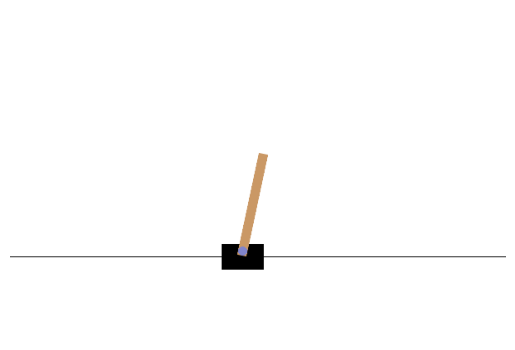

Average return of an untrained agent: 9.6


In [6]:
# Create the environment using gym.make(), you can choose the 'CartPole-v1' for example.
# We use render_mode='rgb_array' to enable visualization compute_avg_return
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, _ = env.reset()

print(env.observation_space.shape)
# TODO Initialize the DQN agent using the DQNAgent class.
agent = DQNAgent(env.action_space, env.observation_space.shape[0])

# TODO Compute the average return over 5 episodes using the untrained agent, also, enable rendering.
avg_return = compute_avg_return(env, agent, num_episodes=5, max_steps=200, render=True)

print("Average return of an untrained agent:", avg_return)

Next, we define the main training loop.

In [7]:
# TODO: Initialize the replay buffer with a capacity of 10000.
replay_buffer = ReplayBuffer(10000)

# Define the number of epochs and the number of steps per epoch.
num_epochs = 200
num_steps = 400

# Training loop
for epoch in range(1, num_epochs + 1):
    # Reset the environment at the beginning of each epoch.
    obs, _ = env.reset()

    # TODO Gather experience for num_steps steps.
    for step in range(num_steps):
        action = agent.act(np.array([obs]), explore=True)
        new_obs, r, done, _, _ =  env.step(action)
        # TODO store data in replay buffer
        replay_buffer.put(obs, action, r, new_obs, done)
        obs = new_obs
        if done:
            obs, _ = env.reset()

    # Learn from the experiences in the replay buffer.
    for _ in range(128):
        # TODO Sample 64 samples from the replay buffer
        states, actions, rewards, next_states, dones = replay_buffer.sample(64)
        # TODO Learn from the sampled data
        agent.learn(states, actions, rewards, next_states, dones)

    # TODO Periodically evaluate the agent's performance and print the average return.
    if epoch % 10 == 0:
        avg_return = compute_avg_return(env, agent, num_episodes=5, max_steps=200, render=False)
        print(f'Epoch {epoch}, Average Return: {avg_return}')

    # TODO Periodically update the target network with the online network weights.
    if epoch % 10 == 0:
        agent.target_update()

print("Training complete.")

Epoch 10, Average Return: 9.8
Epoch 20, Average Return: 10.0
Epoch 30, Average Return: 10.0
Epoch 40, Average Return: 9.8
Epoch 50, Average Return: 10.8
Epoch 60, Average Return: 14.8
Epoch 70, Average Return: 16.4
Epoch 80, Average Return: 35.2
Epoch 90, Average Return: 24.4
Epoch 100, Average Return: 95.6
Epoch 110, Average Return: 92.8
Epoch 120, Average Return: 76.0
Epoch 130, Average Return: 97.6
Epoch 140, Average Return: 170.4
Epoch 150, Average Return: 134.4
Epoch 160, Average Return: 149.4
Epoch 170, Average Return: 143.2
Epoch 180, Average Return: 81.8
Epoch 190, Average Return: 77.4
Epoch 200, Average Return: 181.2
Training complete.


## Step 5: Test the trained model

After training the agent, you want to test it to see how well it performs. In the code below, we will run the agent for a number of episodes and average the returns.

We will also set `render=True` in `compute_avg_return()` function, so that we can see the agent interacting with the environment in real-time.

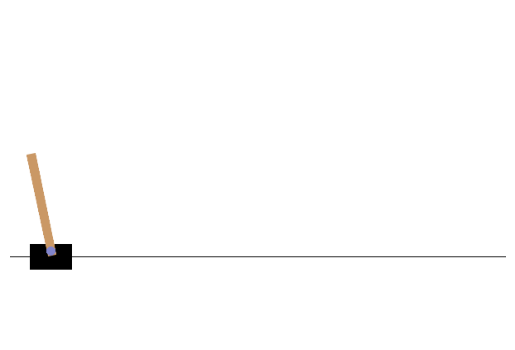

Average return of the trained agent: 164.66666666666666


In [8]:
# Reset the environment
obs, _ = env.reset()

# Run the trained agent on the environment for a number of episodes and print the average return
avg_return = compute_avg_return(env, agent, num_episodes=3, render=True)

print("Average return of the trained agent:", avg_return)

# Close the environment
env.close()